Used to combine repeated annotations into one via consensus and average distance scenes (Niessen et al. 2000 http://link.springer.com/10.1007/978-94-015-9538-4_22)

In [237]:
#import libraries
import numpy as np
import pandas as pd

from shapely.geometry import Polygon, Point, MultiPoint, MultiPolygon
from shapely import minimum_bounding_radius
import geopandas
import matplotlib.pyplot as plt

import requests
from io import BytesIO
from PIL import Image,ImageDraw
import cv2


In [356]:
class CombineAnnots:
    def __init__(self,data,k=0.5,verbose=False,plot=False,image_path = None,remove_disagree=True):
        self.data = data
        self.verbose = verbose
        self.plot = plot
        self.pic_number = data['point_media_key'].unique()
        self.users = data['user'].unique()
        self.classes = data['label_name'].unique()
        self.tags = data['tag_names'].unique()
        self.k = k
        self.image_path = image_path
        self.remove_disagree = remove_disagree

    def filter_annotations(self):
        """
        data = combination df

        For each user combination df 
        1) find #annotators detected colony:
            if < 0.5, remove colony from df
        2) find proportion of label 
            pick majority label, 
            if 50:50, randomly pick label via np.random.choice([labels], None, p)
                p = probability of picking label [#label/all]
            If remove_disagree == True, remove annotations with incorrect label. If False, keep annotations but rename with correct label.
            Repeated for class labels and tag labels
        """

        data_filtered = self.data.copy()

        # 1)

        n=0
        for m in self.pic_number:
            for p in list(dict.fromkeys(self.data[self.data['point_media_key']==m]['individual'])):
                if len(list(dict.fromkeys(self.data[(self.data['point_media_key']==m) & (self.data['individual']==p)]['user']))) < self.k * len(list(dict.fromkeys(self.data['user']))):
                    data_filtered.drop(self.data[(self.data['point_media_key']==m) & (self.data['individual']==p)].index,inplace=True)
                    n+=len(self.data[(self.data['point_media_key']==m) & (self.data['individual']==p)])

        if self.verbose:
            print(f'{n} annotations removed due to less than {self.k} users finding object')

        # 2)

        n_class=0
        n_tag = 0
        prob = {x:len(data_filtered[data_filtered['label_name']==x])/len(data_filtered) for x in list(data_filtered['label_name'].unique())}
        for m in self.pic_number:
            for p in list(dict.fromkeys(data_filtered[data_filtered['point_media_key']==m]['individual'])):
                eg_data = data_filtered[(data_filtered['point_media_key']==m) & (data_filtered['individual']==p)].copy()
                for eg_class in self.classes:
                    grouped_eg_df = eg_data[['user','point_media_id','individual','label_name']].groupby(['point_media_id','individual','label_name'],as_index=False,)['user'].nunique()
                    data_filtered.loc[eg_data[(eg_data['label_name']==eg_class)].index,'prop_class'] = grouped_eg_df.loc[grouped_eg_df['label_name']==eg_class,'user'].item()/grouped_eg_df['user'].sum()
                    if eg_class not in list(eg_data['label_name'].unique()):
                        continue
                    if len(np.where(grouped_eg_df['user']==np.max(grouped_eg_df['user']))) == 1:
                        if grouped_eg_df.loc[grouped_eg_df['label_name']==eg_class,'user'].item() == np.max(grouped_eg_df['user']):
                            n_class+=len(data_filtered[(data_filtered['point_media_key']==m) & (data_filtered['individual']==p)&(data_filtered['label_name']!=eg_class)])
                            if self.remove_disagree == True:
                                data_filtered.drop(eg_data[eg_data['label_name']!=eg_class].index,inplace=True)
                                eg_data.drop(eg_data[eg_data['label_name']!=eg_class].index,inplace=True)

                                grouped_eg_df = eg_data[eg_data['label_name']==eg_class][['user','point_media_id','individual','label_name','tag_names']].groupby(['point_media_id','individual','label_name','tag_names'],as_index=False,)['user'].nunique()
                                for eg_tag in self.tags:
                                    if eg_tag not in list(eg_data[(eg_data['label_name']==eg_class)]['tag_names'].unique()):
                                        continue
                                    data_filtered.loc[eg_data[(eg_data['label_name']==eg_class)&(eg_data['tag_names']==eg_tag)].index,'prop_tag'] = grouped_eg_df.loc[grouped_eg_df['tag_names']==eg_tag,'user'].item()/grouped_eg_df['user'].sum()
                                    if eg_tag not in list(eg_data['tag_names'].unique()):
                                        continue
                                    if len(np.where(grouped_eg_df['user']==np.max(grouped_eg_df['user']))) == 1:
                                        if grouped_eg_df.loc[grouped_eg_df['tag_names']==eg_tag,'user'].item() == np.max(grouped_eg_df['user']):
                                            n_tag+=len(data_filtered[(data_filtered['point_media_key']==m) & (data_filtered['individual']==p)&(data_filtered['tag_names']!=eg_tag)])
                                            data_filtered.drop(eg_data[eg_data['tag_names']!=eg_tag].index,inplace=True)
                                            eg_data.drop(eg_data[eg_data['tag_names']!=eg_tag].index,inplace=True)
                                            break
                                        else:
                                            n_tag+=len(data_filtered[(data_filtered['point_media_key']==m) & (data_filtered['individual']==p)&(data_filtered['tag_names']==eg_tag)])
                                            data_filtered.drop(eg_data[eg_data['tag_names']==eg_tag].index,inplace=True)
                                            eg_data.drop(eg_data[eg_data['tag_names']==eg_tag].index,inplace=True)
                                    else:
                                        prob2 = [prob[x] for x in list(grouped_eg_df.loc[np.where(grouped_eg_df['user']==np.max(grouped_eg_df['user'])),'tag_names'])]
                                        random_tag = np.random.choice(list(grouped_eg_df.loc[np.where(grouped_eg_df['user']==np.max(grouped_eg_df['user'])),'tag_names']),None,p=[x/sum(prob2) for x in prob2])
                                        n_tag+=len(data_filtered[(data_filtered['point_media_key']==m) & (data_filtered['individual']==p)&(data_filtered['tag_names']!=random_tag)])
                                        data_filtered.drop(eg_data[eg_data['tag_names']!=random_tag].index,inplace=True)
                                        eg_data.drop(eg_data[eg_data['tag_names']!=random_tag].index,inplace=True)
                                        break
                                break
                            
                            else:
                                data_filtered.loc[eg_data[eg_data['label_name']!=eg_class].index,'label_name'] = eg_class

                                grouped_eg_df = eg_data[eg_data['label_name']==eg_class][['user','point_media_id','individual','label_name','tag_names']].groupby(['point_media_id','individual','label_name','tag_names'],as_index=False,)['user'].nunique()
                                for eg_tag in self.tags:
                                    if eg_tag not in list(eg_data[(eg_data['label_name']==eg_class)]['tag_names'].unique()):
                                        continue
                                    data_filtered.loc[eg_data[(eg_data['label_name']==eg_class)&(eg_data['tag_names']==eg_tag)].index,'prop_tag'] = grouped_eg_df.loc[grouped_eg_df['tag_names']==eg_tag,'user'].item()/grouped_eg_df['user'].sum()
                                    if eg_tag not in list(eg_data['tag_names'].unique()):
                                        continue
                                    if len(np.where(grouped_eg_df['user']==np.max(grouped_eg_df['user']))) == 1:
                                        if grouped_eg_df.loc[grouped_eg_df['tag_names']==eg_tag,'user'].item() == np.max(grouped_eg_df['user']):
                                            n_tag+=len(data_filtered[(data_filtered['point_media_key']==m) & (data_filtered['individual']==p)&(data_filtered['tag_names']!=eg_tag)])
                                            data_filtered.loc[eg_data[eg_data['tag_names']!=eg_tag].index,'tag_names'] = eg_tag
                                            break
                                        else:
                                            n_tag+=len(data_filtered[(data_filtered['point_media_key']==m) & (data_filtered['individual']==p)&(data_filtered['tag_names']==eg_tag)])
                                    else:
                                        prob2 = [prob[x] for x in list(grouped_eg_df.loc[np.where(grouped_eg_df['user']==np.max(grouped_eg_df['user'])),'tag_names'])]
                                        random_tag = np.random.choice(list(grouped_eg_df.loc[np.where(grouped_eg_df['user']==np.max(grouped_eg_df['user'])),'tag_names']),None,p=[x/sum(prob2) for x in prob2])
                                        n_tag+=len(data_filtered[(data_filtered['point_media_key']==m) & (data_filtered['individual']==p)&(data_filtered['tag_names']!=random_tag)])
                                        data_filtered.loc[eg_data[eg_data['tag_names']!=random_tag].index,'tag_names'] = random_tag
                                        break
                                break

                        else:
                            n_class+=len(data_filtered[(data_filtered['point_media_key']==m) & (data_filtered['individual']==p)&(data_filtered['label_name']==eg_class)])
                            if self.remove_disagree == True:
                                data_filtered.drop(eg_data[eg_data['label_name']==eg_class].index,inplace=True)
                                eg_data.drop(eg_data[eg_data['label_name']==eg_class].index,inplace=True)

                    else:
                        prob2 = [prob[x] for x in list(grouped_eg_df.loc[np.where(grouped_eg_df['user']==np.max(grouped_eg_df['user'])),'label_name'])]
                        random_class = np.random.choice(list(grouped_eg_df.loc[np.where(grouped_eg_df['user']==np.max(grouped_eg_df['user'])),'label_name']),None,p=[x/sum(prob2) for x in prob2])
                        n_class+=len(data_filtered[(data_filtered['point_media_key']==m) & (data_filtered['individual']==p)&(data_filtered['label_name']!=random_class)])
                        if self.remove_disagree == True:
                            data_filtered.drop(eg_data[eg_data['label_name']!=random_class].index,inplace=True)
                            eg_data.drop(eg_data[eg_data['label_name']!=random_class].index,inplace=True)

                            grouped_eg_df = eg_data[eg_data['label_name']==eg_class][['user','point_media_id','individual','label_name','tag_names']].groupby(['point_media_id','individual','label_name','tag_names'],as_index=False,)['user'].nunique()
                            for eg_tag in self.tags:
                                if eg_tag not in list(eg_data[(eg_data['label_name']==eg_class)]['tag_names'].unique()):
                                    continue
                                data_filtered.loc[eg_data[(eg_data['label_name']==eg_class)&(eg_data['tag_names']==eg_tag)].index,'prop_tag'] = grouped_eg_df.loc[grouped_eg_df['tag_names']==eg_tag,'user'].item()/grouped_eg_df['user'].sum()
                                if eg_tag not in list(eg_data['tag_names'].unique()):
                                    continue
                                if len(np.where(grouped_eg_df['user']==np.max(grouped_eg_df['user']))) == 1:
                                    if grouped_eg_df.loc[grouped_eg_df['tag_names']==eg_tag,'user'].item() == np.max(grouped_eg_df['user']):
                                        n_tag+=len(data_filtered[(data_filtered['point_media_key']==m) & (data_filtered['individual']==p)&(data_filtered['tag_names']!=eg_tag)])
                                        data_filtered.drop(eg_data[eg_data['tag_names']!=eg_tag].index,inplace=True)
                                        eg_data.drop(eg_data[eg_data['tag_names']!=eg_tag].index,inplace=True)
                                        break
                                    else:
                                        n_tag+=len(data_filtered[(data_filtered['point_media_key']==m) & (data_filtered['individual']==p)&(data_filtered['tag_names']==eg_tag)])
                                        data_filtered.drop(eg_data[eg_data['tag_names']==eg_tag].index,inplace=True)
                                        eg_data.drop(eg_data[eg_data['tag_names']==eg_tag].index,inplace=True)
                                else:
                                    prob2 = [prob[x] for x in list(grouped_eg_df.loc[np.where(grouped_eg_df['user']==np.max(grouped_eg_df['user'])),'tag_names'])]
                                    random_tag = np.random.choice(list(grouped_eg_df.loc[np.where(grouped_eg_df['user']==np.max(grouped_eg_df['user'])),'tag_names']),None,p=[x/sum(prob2) for x in prob2])
                                    n_tag+=len(data_filtered[(data_filtered['point_media_key']==m) & (data_filtered['individual']==p)&(data_filtered['tag_names']!=random_tag)])
                                    data_filtered.drop(eg_data[eg_data['tag_names']!=random_tag].index,inplace=True)
                                    eg_data.drop(eg_data[eg_data['tag_names']!=random_tag].index,inplace=True)
                                    break
                            break
                        else:
                            data_filtered.loc[eg_data[eg_data['label_name']!=random_class].index,'label_name'] = random_class

                            grouped_eg_df = eg_data[eg_data['label_name']==random_class][['user','point_media_id','individual','label_name','tag_names']].groupby(['point_media_id','individual','label_name','tag_names'],as_index=False,)['user'].nunique()
                            for eg_tag in self.tags:
                                if eg_tag not in list(eg_data[(eg_data['label_name']==eg_class)]['tag_names'].unique()):
                                    continue
                                data_filtered.loc[eg_data[(eg_data['label_name']==random_class)&(eg_data['tag_names']==eg_tag)].index,'prop_tag'] = grouped_eg_df.loc[grouped_eg_df['tag_names']==eg_tag,'user'].item()/grouped_eg_df['user'].sum()
                                if eg_tag not in list(eg_data['tag_names'].unique()):
                                    continue
                                if len(np.where(grouped_eg_df['user']==np.max(grouped_eg_df['user']))) == 1:
                                    if grouped_eg_df.loc[grouped_eg_df['tag_names']==eg_tag,'user'].item() == np.max(grouped_eg_df['user']):
                                        n_tag+=len(data_filtered[(data_filtered['point_media_key']==m) & (data_filtered['individual']==p)&(data_filtered['tag_names']!=eg_tag)])
                                        data_filtered.loc[eg_data[eg_data['tag_names']!=eg_tag].index,'tag_names'] = eg_tag
                                        break
                                    else:
                                        n_tag+=len(data_filtered[(data_filtered['point_media_key']==m) & (data_filtered['individual']==p)&(data_filtered['tag_names']==eg_tag)])
                                else:
                                    prob2 = [prob[x] for x in list(grouped_eg_df.loc[np.where(grouped_eg_df['user']==np.max(grouped_eg_df['user'])),'tag_names'])]
                                    random_tag = np.random.choice(list(grouped_eg_df.loc[np.where(grouped_eg_df['user']==np.max(grouped_eg_df['user'])),'tag_names']),None,p=[x/sum(prob2) for x in prob2])
                                    n_tag+=len(data_filtered[(data_filtered['point_media_key']==m) & (data_filtered['individual']==p)&(data_filtered['tag_names']!=random_tag)])
                                    data_filtered.loc[eg_data[eg_data['tag_names']!=random_tag].index,'tag_names'] = random_tag
                                    break
                            break
        
        if self.verbose:
            if self.remove_disagree == True:
                print(f'{n_class} more annotations with a non-majority class label removed')
                print(f'{n_tag} more annotations with a non-majority tag label removed')
            else:
                print(f'{n_class} more annotations with a non-majority class label renamed with the majority class label')
                print(f'{n_tag} more annotations with a non-majority tag label renamed with the majority tag label')

        return data_filtered
    
    def create_average_df(self,filter_annots=True):
        """
        Create new dataframe for combined annotations
        """        
        av_df = pd.DataFrame()

        if filter_annots:
            filtered_data = self.filter_annotations()
        else:
            filtered_data = self.data.copy()
            for ind in filtered_data['individual'].unique():
                grouped_class = filtered_data[filtered_data['individual']==ind].groupby(['label_name'],as_index=False)['user'].nunique()
                grouped_tag = filtered_data[filtered_data['individual']==ind].groupby(['label_name','tag_names'],as_index=False)['user'].nunique()
                for idx in filtered_data[filtered_data['individual']==ind].index:
                    filtered_data.loc[idx,'prop_class'] = grouped_class.loc[grouped_class['label_name']==filtered_data.loc[idx,'label_name'],'user'].item()/grouped_class['user'].sum().item()
                    filtered_data.loc[idx,'prop_tag'] = grouped_tag.loc[(grouped_tag['label_name']==filtered_data.loc[idx,'label_name'])&(grouped_tag['tag_names']==filtered_data.loc[idx,'tag_names']),'user'].item()/grouped_tag[grouped_tag['label_name']==filtered_data.loc[idx,'label_name']]['user'].sum().item()

        random_ind_plot = np.random.choice(filtered_data['individual'].unique()) #choose random annotation to plot if plot == True


        total_pols = 0
        total_points = 0
        for m in self.pic_number:

            try:
                image_url = filtered_data[filtered_data['point_media_key']==m]['point_media_path_best'].unique().item()
                response = requests.get(image_url)
                img = Image.open(BytesIO(response.content))
            except:
                try:
                    img = Image.open(self.image_path+m)
                except:
                    print('No/incorrect path found for images, please add working image_path')
                    return
            img_width = img.width
            img_height = img.height
            img.close()

            for p in filtered_data[filtered_data['point_media_key']==m]['individual'].unique():
                eg_data = filtered_data[(filtered_data['point_media_key']==m)&(filtered_data['individual']==p)].copy()
                for eg_class in self.classes:
                    if eg_class not in (eg_data['label_name'].unique()):
                        continue
                    for eg_tag in self.tags:
                        if eg_tag not in list(eg_data[eg_data['label_name']==eg_class]['tag_names'].unique()):
                            continue

                        eg_av_df = eg_data.drop_duplicates(['point_media_key','individual']).copy()
                        if len(eg_av_df) != 1:
                            print('eg_av_df not a length of 1')
                            return
                        eg_av_df = eg_av_df[['point_media_deployment_campaign_key', 'point_media_deployment_key', 'point_media_id', 'point_media_key']]

                        av_dict,n_pols,n_points = self.average_mask(eg_data[(eg_data['label_name']==eg_class)&(eg_data['tag_names']==eg_tag)],img_width,img_height,random_ind_plot)
                        total_pols+=n_pols
                        total_points+=n_points

                        eg_av_df['user'] = av_dict['user']
                        eg_av_df['individual'] = av_dict['individual']
                        eg_av_df['label_name'] = av_dict['label_name']
                        eg_av_df['tag_names'] = av_dict['tag_names']
                        eg_av_df['shape'] = av_dict['shape']
                        if av_dict['shape'] == 'point':
                            eg_av_df['x'] = list([av_dict['x']])
                            eg_av_df['y'] = list([av_dict['y']])
                        else:
                            eg_av_df['x'] = list(av_dict['x'])
                            eg_av_df['y'] = list(av_dict['y'])
                        eg_av_df['x_centroid'] = av_dict['x_centroid']
                        eg_av_df['y_centroid'] = av_dict['y_centroid']
                        eg_av_df['area'] = av_dict['area']
                        eg_av_df['prop_class'] = av_dict['prop_class']
                        eg_av_df['prop_tag'] = av_dict['prop_tag']

                        av_df = pd.concat([av_df,eg_av_df],ignore_index=True)

        if self.verbose:
            n_users = len(self.data['user'].unique())
            print(f"Created {total_pols} new mask annotations and {total_points} new point annotations by combining {n_users} users' annotations together")
        
        return av_df

    def average_mask(self,eg_data,img_width,img_height,ind_plot=None):

        distance_scenes = []

        user_comb = '-'.join(eg_data['user'].unique())

        if np.sum(eg_data['area']) == 0: #all point annotations

            new_x,new_y = np.asarray(MultiPoint([(eg_data.loc[i,'x'],eg_data.loc[i,'y']) for i in eg_data.index]).centroid.xy).flatten()

            av_dict = {
                'user': user_comb,
                'individual': eg_data['individual'].unique().item(),
                'label_name': eg_data['label_name'].unique().item(),
                'tag_names': eg_data['tag_names'].unique().item(),
                'shape': 'point',
                'x': new_x,
                'y': new_y,
                'x_centroid': new_x,
                'y_centroid': new_y,
                'area': 0,
                'prop_class': eg_data['prop_class'].unique().item(),
                'prop_tag': eg_data['prop_tag'].unique().item(),
            }

            if self.plot:
                if eg_data['individual'].unique().item() == ind_plot:
                    fig,ax = plt.subplots()
                    geopandas.GeoSeries([MultiPoint([(eg_data.loc[i,'x'],eg_data.loc[i,'y']) for i in eg_data.index])]).plot(ax=ax,alpha=0.7)
                    geopandas.GeoSeries([MultiPoint([(eg_data.loc[i,'x'],eg_data.loc[i,'y']) for i in eg_data.index]).centroid]).plot(ax=ax,alpha=0.7,label = 'centroid')
                    ax.set_title(f'Combined plot of example annotations:\nindividual {ind_plot}')
                    ax.legend(loc='best',bbox_to_anchor=(0.5,0,0.5,0.1))
                    fig.tight_layout()
                    fig.show()

            return av_dict,0,1
        
        for eg_user in eg_data['user'].unique():
            if np.sum(eg_data[eg_data['user']==eg_user]['area']) == 0: #dont include point annotations in distance scenes
                continue
            distance_scenes.append(self.distance_scene(eg_data[eg_data['user']==eg_user],img_width,img_height))

        combine_pol = sum(distance_scenes)           
        av_pol = combine_pol.copy()
        av_pol[np.where(combine_pol <= 0)] = True
        av_pol[np.where(combine_pol > 0)] = False

        new_xs,new_ys = self.get_poly_coords(av_pol)
        new_xs = np.asarray(new_xs)/img_width
        new_ys = np.asarray(new_ys)/img_height
        new_mask = MultiPolygon([Polygon(list(zip(new_xs[x],new_ys[x]))) for x in range(len(new_xs))])
        new_x_centroid,new_y_centroid = np.asarray(new_mask.centroid.xy).flatten()
        new_area = new_mask.area


        av_dict = {
            'user': user_comb,
            'individual': eg_data['individual'].unique().item(),
            'label_name': eg_data['label_name'].unique().item(),
            'tag_names': eg_data['tag_names'].unique().item(),
            'shape': 'polygon',
            'x': new_xs,
            'y': new_ys,
            'x_centroid': new_x_centroid,
            'y_centroid': new_y_centroid,
            'area': new_area,
            'prop_class': eg_data['prop_class'].unique().item(),
            'prop_tag': eg_data['prop_tag'].unique().item(),
        }

        if self.plot:
            if eg_data['individual'].unique().item() == ind_plot:
                fig,axs = plt.subplots(nrows=1,ncols=len(eg_data[eg_data['area']>0]['user'].unique())+3,figsize=[20,3])
                buffer = 50 #number of pixels to buffer plots 
                # comb_coords = []
                coords = [[list(zip(np.asarray(eg_data.loc[i,'x'])*img_width,np.asarray(eg_data.loc[i,'y'])*img_height)) for i in eg_data[eg_data['user']==eg_user].index if eg_data.loc[i,'area']>0] for eg_user in eg_data[eg_data['area']>0]['user'].unique()]
                x_min,y_min = np.int16(np.min([np.min(x,axis=0) for x in [x for xs in coords for x in xs]],axis=0).flatten())
                x_max,y_max = np.int16(np.max([np.max(x,axis=0) for x in [x for xs in coords for x in xs]],axis=0).flatten())
                mult_polys = MultiPolygon([Polygon(x) for x in [x for xs in coords for x in xs]])
                min_rad = minimum_bounding_radius(mult_polys)  

                axs[0].set_xlim(x_min-buffer,x_max+buffer)
                axs[0].set_ylim(y_min-buffer,y_max+buffer)

                geopandas.GeoSeries([MultiPolygon([Polygon(x) for x in xs]) for xs in coords]).boundary.plot(ax=axs[0],alpha=0.7,cmap='tab20')

                axs[len(eg_data[eg_data['area']>0]['user'].unique())+1].imshow(combine_pol[y_min-buffer:y_max+buffer,:][:,x_min-buffer:x_max+buffer],vmin=min_rad*(-1),vmax=np.sqrt(min_rad**2+buffer**2))
                axs[len(eg_data[eg_data['area']>0]['user'].unique())+1].set_ylim(axs[len(eg_data[eg_data['area']>0]['user'].unique())+1].get_ylim()[::-1])
                axs[len(eg_data[eg_data['area']>0]['user'].unique())+2].imshow(av_pol)
                axs[len(eg_data[eg_data['area']>0]['user'].unique())+2].set_xlim(x_min-buffer,x_max+buffer)
                axs[len(eg_data[eg_data['area']>0]['user'].unique())+2].set_ylim(y_min-buffer,y_max+buffer)

                for eg_user in eg_data[eg_data['area']>0]['user'].unique():
                    if np.sum(eg_data[eg_data['user']==eg_user]['area']) == 0:
                        continue
                    mult_polys = MultiPolygon([Polygon(list(zip(eg_data.loc[i,'x'],eg_data.loc[i,'y']))) for i in eg_data[eg_data['user']==eg_user].index if eg_data.loc[i,'area']>0])
                    
                    coords = [list(zip(np.asarray(eg_data.loc[i,'x'])*img_width,np.asarray(eg_data.loc[i,'y'])*img_height)) for i in eg_data[eg_data['user']==eg_user].index if eg_data.loc[i,'area']>0]
                    min_rad = minimum_bounding_radius(mult_polys)
                    axs[list(eg_data[eg_data['area']>0]['user'].unique()).index(eg_user)+1].imshow(distance_scenes[list(eg_data[eg_data['area']>0]['user'].unique()).index(eg_user)],vmin=min_rad*(-1),vmax=np.sqrt(min_rad**2+buffer**2))
                    axs[list(eg_data[eg_data['area']>0]['user'].unique()).index(eg_user)+1].set_xlim(x_min-buffer,x_max+buffer)
                    axs[list(eg_data[eg_data['area']>0]['user'].unique()).index(eg_user)+1].set_ylim(y_min-buffer,y_max+buffer)
                    axs[list(eg_data[eg_data['area']>0]['user'].unique()).index(eg_user)+1].set_title(f"Distance\nscene {list(eg_data[eg_data['area']>0]['user'].unique()).index(eg_user)+1}")
                    axs[list(eg_data[eg_data['area']>0]['user'].unique()).index(eg_user)+1].axis('off')

                axs[0].axis('off')
                axs[len(eg_data[eg_data['area']>0]['user'].unique())+1].axis('off')
                axs[len(eg_data[eg_data['area']>0]['user'].unique())+2].axis('off')

                axs[0].set_title('Drawn masks')
                axs[len(eg_data[eg_data['area']>0]['user'].unique())+1].set_title('Combined\ndistance scenes')
                axs[len(eg_data[eg_data['area']>0]['user'].unique())+2].set_title('Average mask')
                fig.suptitle(f'Combined plot of example annotations:\nindividual {ind_plot}')
                fig.tight_layout()
                fig.show()

        return av_dict,1,0

    def get_poly_coords(self,mask):
        #to convert binary mask into polygon coordinates 
        
        contours, _ = cv2.findContours(np.asarray(mask,np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        polygons = []
        xs = []
        ys = []
        for object in contours:
            coords = []
            x = []
            y = []

            for point in object:
                coords.append([point[0][0],point[0][1]])
                x.append(point[0][0])
                y.append(point[0][1])

            polygons.append(coords)
            xs.append(x)
            ys.append(y)
            
            return xs,ys

    def distance_scene(self, eg_data, img_width, img_height):

        #creating distance scene for polygon
        img = np.zeros((img_height, img_width), np.uint8)
        pol_coords = []
        for idx in eg_data.index:
            if eg_data.loc[idx,'area'] == 0:
                continue
            xcoord = np.asarray(eg_data.loc[idx,'x'])*img_width
            ycoord = np.asarray(eg_data.loc[idx,'y'])*img_height
            coords = list(zip(xcoord,ycoord))
            pol_coords.append(coords)
            cv2.polylines(img, np.int32([coords]),True,(255,0,0),1)
        img = 255 - img
        dist = cv2.distanceTransform(img, cv2.DIST_L2, maskSize=0)

        #inverting inside of polygon pixel distances to be negative 
        img = Image.new('L', (img_width, img_height), 0)
        for coords in pol_coords:
            ImageDraw.Draw(img).polygon(coords, outline=1, fill=1)
        mask = np.array(img)
        dist[np.where(mask==1)] = dist[np.where(mask==1)] *(-1)

        return dist
    

examples of code being used to combine repeated annotations

In [342]:
data_dir = #directory for matched annotation dataframe
data = pd.read_pickle(data_dir+'match_eg_df.zip')

data.loc[data['area']>0,'shape'] = 'polygon'
data.loc[data['area']>0,'shape_type'] = 'lines'
data.loc[data['area']==0,'shape'] = 'point'
data.loc[data['area']==0,'shape_type'] = 'markers'
data.sort_values(['user','area'],ascending=[True,False],ignore_index=True,inplace=True)
data.dropna(subset='point_x',inplace=True)

data.loc[data['label_name']=='Scleractinia','tag_names'] = data.loc[data['label_name']=='Scleractinia','tag_names'].fillna('Uncertain')
data['tag_names'].fillna('NA',inplace=True)

data.loc[data['tag_names'].str.contains('Live'),'tag_names'] = 'Live'
data.loc[data['tag_names'].str.contains('Dead'),'tag_names'] = 'Dead'
data.loc[data['tag_names'].str.contains('Bleached'),'tag_names'] = 'Live'
data.loc[data['tag_names'].str.contains('Uncertain'),'tag_names'] = 'Uncertain'
data.loc[data['tag_names'].str.contains('Too Small For Polygon'),'tag_names'] = 'Uncertain'

In [338]:
filtered_data = CombineAnnots(data,verbose=True).filter_annotations()

440 annotations removed due to less than 0.5 users finding object
7 more annotations with a non-majority class label removed
190 more annotations with a non-majority tag label removed


0 annotations removed due to less than 0.5 users finding object
0 more annotations with a non-majority class label removed
3 more annotations with a non-majority tag label removed
Created 1 new mask annotations and 0 new point annotations by combining 10 users' annotations together


/tmp/ipykernel_3355290/1680263607.py:394: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


,point_media_deployment_campaign_key,point_media_deployment_key,point_media_id,point_media_key,user,individual,label_name,tag_names,shape,x,y,x_centroid,y_centroid,area,prop_class,prop_tag
0,NaN,NaN,4962217,PCO_190916132825063395_FC.png,4RXFW5-A4JI9Q-ITNVWC-KB5RZ5-S0YC1V-V6Y749-WKSN...,125395,Scleractinia,Dead,polygon,"[0.51953125, 0.519140625, 0.51875, 0.51875, 0....","[0.42268518518518516, 0.42314814814814816, 0.4...",0.553333,0.462782,0.002916,1.0,0.909091


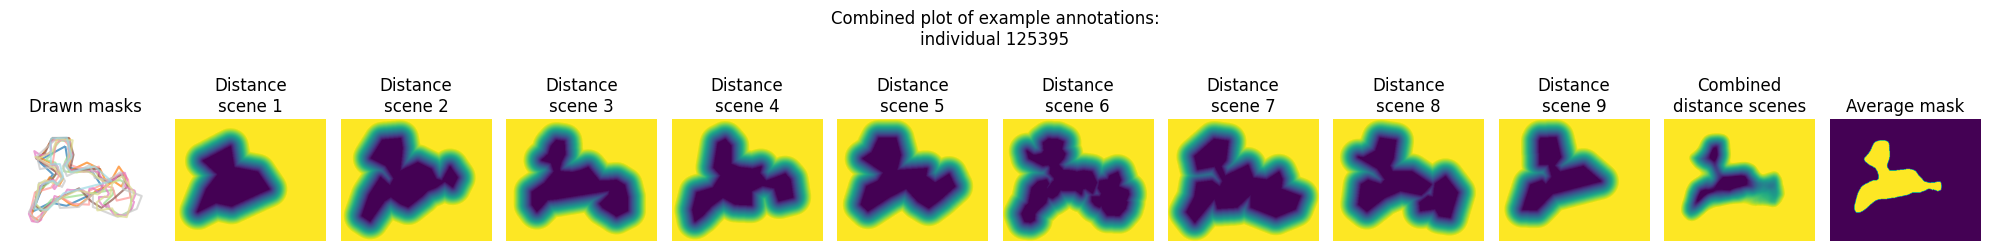

In [358]:
eg_data = data[data['individual']==data['individual'].unique()[0]].copy()
eg_data['point_media_key'] = eg_data['point_media_key'].unique().item().replace(' ','')
im_path = #directory for images the annotations are from
eg_av_df = CombineAnnots(eg_data,verbose=True,plot=True,image_path = im_path).create_average_df(filter_annots=True)
eg_av_df.head()

105 annotations removed due to less than 0.5 users finding object
0 more annotations with a non-majority class label removed
40 more annotations with a non-majority tag label removed


/tmp/ipykernel_3355290/1680263607.py:303: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Created 136 new mask annotations and 119 new point annotations by combining 3 users' annotations together


,point_media_deployment_campaign_key,point_media_deployment_key,point_media_id,point_media_key,user,individual,label_name,tag_names,shape,x,y,x_centroid,y_centroid,area,prop_class,prop_tag
0,NaN,NaN,4962217,PCO_190916132825063395_FC.png,4RXFW5-A4JI9Q,125395,Scleractinia,Dead,polygon,"[0.518359375, 0.51796875, 0.517578125, 0.51718...","[0.4203703703703704, 0.42083333333333334, 0.42...",0.550786,0.461437,0.003002,1.0,1.0
1,NaN,NaN,4962217,PCO_190916132825063395_FC.png,4RXFW5-5DEH8P-A4JI9Q,120146,Scleractinia,Live,polygon,"[0.58828125, 0.587890625, 0.5875, 0.587109375,...","[0.37407407407407406, 0.37453703703703706, 0.3...",0.586089,0.401781,0.001325,1.0,1.0
2,NaN,NaN,4962217,PCO_190916132825063395_FC.png,4RXFW5-5DEH8P-A4JI9Q,120794,Scleractinia,Dead,polygon,"[0.683984375, 0.68359375, 0.683203125, 0.68281...","[0.015277777777777777, 0.01574074074074074, 0....",0.687002,0.049064,0.001846,1.0,1.0
3,NaN,NaN,4962217,PCO_190916132825063395_FC.png,4RXFW5-5DEH8P-A4JI9Q,119971,Scleractinia,Live,polygon,"[0.8734375, 0.873046875, 0.87265625, 0.8722656...","[0.2828703703703704, 0.2833333333333333, 0.283...",0.874722,0.302916,0.000695,1.0,1.0
4,NaN,NaN,4962217,PCO_190916132825063395_FC.png,4RXFW5-5DEH8P-A4JI9Q,120443,Scleractinia,Live,polygon,"[0.50078125, 0.500390625, 0.5, 0.499609375, 0....","[0.3990740740740741, 0.399537037037037, 0.3995...",0.500668,0.413733,0.000513,1.0,1.0


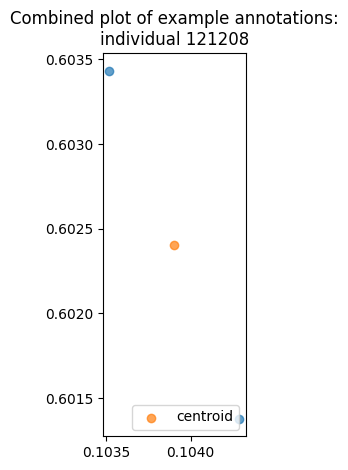

In [357]:
eg_data = pd.concat([data[data['user']==eg_user] for eg_user in data['user'].unique()[:3]])
eg_data['point_media_key'] = [x.replace(' ','') for x in eg_data['point_media_key']]
im_path = #directory for images the annotations are from
eg_av_df = CombineAnnots(eg_data,verbose=True,plot=True,image_path = im_path).create_average_df(filter_annots=True)
eg_av_df.head()